In [139]:
import torch
foo =  torch.rand((3, 5))

foo

tensor([[0.5974, 0.0505, 0.3552, 0.6191, 0.7688],
        [0.0489, 0.9987, 0.4672, 0.8783, 0.3374],
        [0.8400, 0.6545, 0.3348, 0.8198, 0.9866]])

In [140]:
foo.mean(0, keepdim=True)


tensor([[0.4955, 0.5679, 0.3857, 0.7724, 0.6976]])

E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.


The bias of the last linear layer of the network is being trained.
The inputs get zeroed. So we're just learning the unconditioned probability distribution of characters in the training set.



In [141]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [142]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [143]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [144]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [147]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers:
    if isinstance(layer, Linear):
      layer.weight *= 0 #5/3
      layer.bias *= 0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [200]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 2.6169
  10000/  20000: 3.1447


In [203]:
jlkjlayers[-1].weight

tensor([[-0., 0., -0.,  ..., -0., -0., 0.],
        [0., -0., -0.,  ..., 0., 0., -0.],
        [0., -0., -0.,  ..., -0., 0., -0.],
        ...,
        [-0., 0., 0.,  ..., -0., -0., 0.],
        [-0., -0., 0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., 0., 0., -0.]], requires_grad=True)

tensor(0.0002, grad_fn=<SumBackward0>)

tensor([0.1398, 0.1492, 0.0114, 0.0153, 0.0244, 0.0899, 0.0040, 0.0086, 0.0334,
        0.0758, 0.0127, 0.0222, 0.0616, 0.0284, 0.0811, 0.0344, 0.0045, 0.0017,
        0.0561, 0.0359, 0.0242, 0.0134, 0.0110, 0.0042, 0.0033, 0.0428, 0.0107],
       grad_fn=<DivBackward0>)
tensor(1., grad_fn=<SumBackward0>)


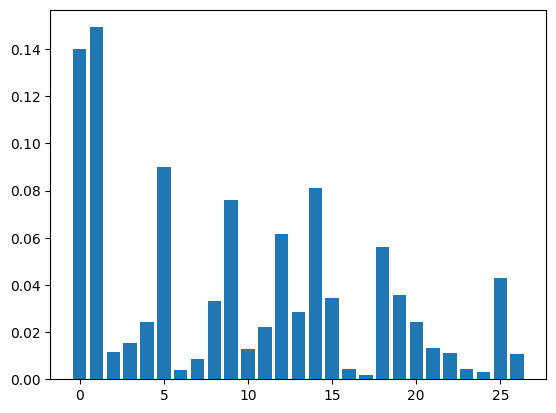

.  0.14
a  0.15
b  0.01
c  0.02
d  0.02
e  0.09
f  0.00
g  0.01
h  0.03
i  0.08
j  0.01
k  0.02
l  0.06
m  0.03
n  0.08
o  0.03
p  0.00
q  0.00
r  0.06
s  0.04
t  0.02
u  0.01
v  0.01
w  0.00
x  0.00
y  0.04
z  0.01


In [232]:
import matplotlib.pyplot as plt

prob = torch.exp(layers[-1].bias)
prob = prob / prob.sum()
print(prob)
print(prob.sum())

bias = prob.detach().numpy()  # Convert tensor to numpy array
indices = range(len(bias))  # Create indices for x-axis

plt.bar(indices, bias)
plt.show()

for i, a in enumerate(bias):
    print(f'{itos[i]} {a: .2f}')

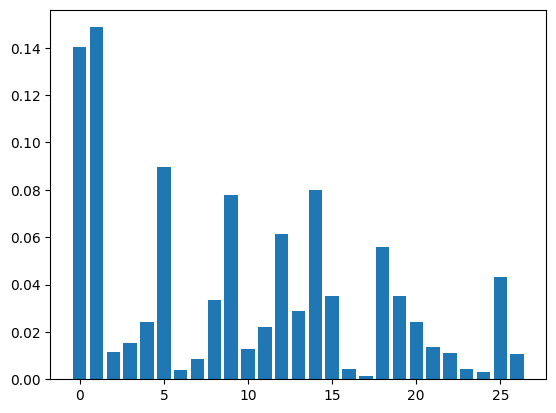

.  0.14
a  0.15
b  0.01
c  0.02
d  0.02
e  0.09
f  0.00
g  0.01
h  0.03
i  0.08
j  0.01
k  0.02
l  0.06
m  0.03
n  0.08
o  0.03
p  0.00
q  0.00
r  0.06
s  0.04
t  0.02
u  0.01
v  0.01
w  0.00
x  0.00
y  0.04
z  0.01


In [241]:
# Demonstration that we're just learning the probability dist of characters.



# Sample all the letters in W_tr
counts = torch.zeros(27, dtype=float)
for w in words[:n1]:
    for ch in w:
        counts[stoi[ch]] += 1
    counts[0] += 1
probs = counts / counts.sum()
indices = range(len(probs))  # Create indices for x-axis

plt.bar(indices, probs)
plt.show()

for i, a in enumerate(probs):
    print(f'{itos[i]} {a: .2f}')

In [201]:
layers[-1].out

tensor([[ 1.9114,  1.9752, -0.5934, -0.3013,  0.1652,  1.4694, -1.6438, -0.8736,
          0.4786,  1.2984, -0.4898,  0.0689,  1.0919,  0.3183,  1.3639,  0.5090,
         -1.5232, -2.4783,  0.9971,  0.5513,  0.1557, -0.4355, -0.6337, -1.5958,
         -1.8505,  0.7274, -0.6625],
        [ 1.9114,  1.9752, -0.5934, -0.3013,  0.1652,  1.4694, -1.6438, -0.8736,
          0.4786,  1.2984, -0.4898,  0.0689,  1.0919,  0.3183,  1.3639,  0.5090,
         -1.5232, -2.4783,  0.9971,  0.5513,  0.1557, -0.4355, -0.6337, -1.5958,
         -1.8505,  0.7274, -0.6625],
        [ 1.9114,  1.9752, -0.5934, -0.3013,  0.1652,  1.4694, -1.6438, -0.8736,
          0.4786,  1.2984, -0.4898,  0.0689,  1.0919,  0.3183,  1.3639,  0.5090,
         -1.5232, -2.4783,  0.9971,  0.5513,  0.1557, -0.4355, -0.6337, -1.5958,
         -1.8505,  0.7274, -0.6625],
        [ 1.9114,  1.9752, -0.5934, -0.3013,  0.1652,  1.4694, -1.6438, -0.8736,
          0.4786,  1.2984, -0.4898,  0.0689,  1.0919,  0.3183,  1.3639,  0.5090

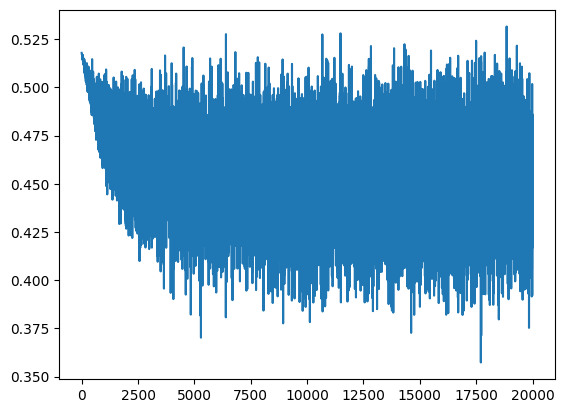

In [149]:
plt.plot(lossi)


layer 0 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 2 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 4 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 6 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 10 (    Linear): mean +0.00, std 1.16, saturated: 44.44%


Text(0.5, 1.0, 'activation distribution')

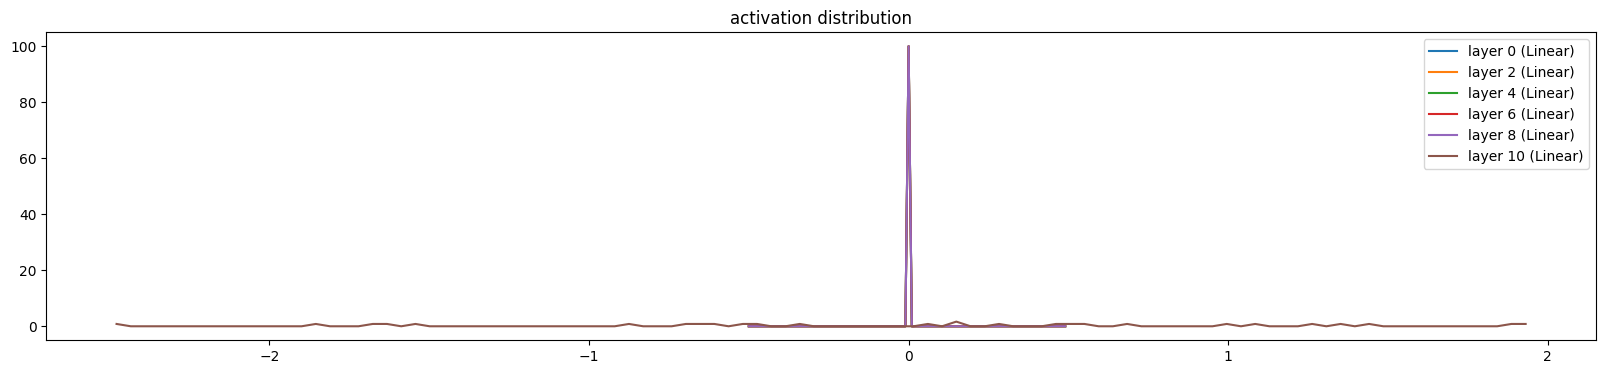

In [242]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<AddBackward0>)
grad: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
layer 0 (    Linear): mean +0.000000, std 0.000000e+00
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<AddBackward0>)
grad: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
   

Text(0.5, 1.0, 'gradient distribution')

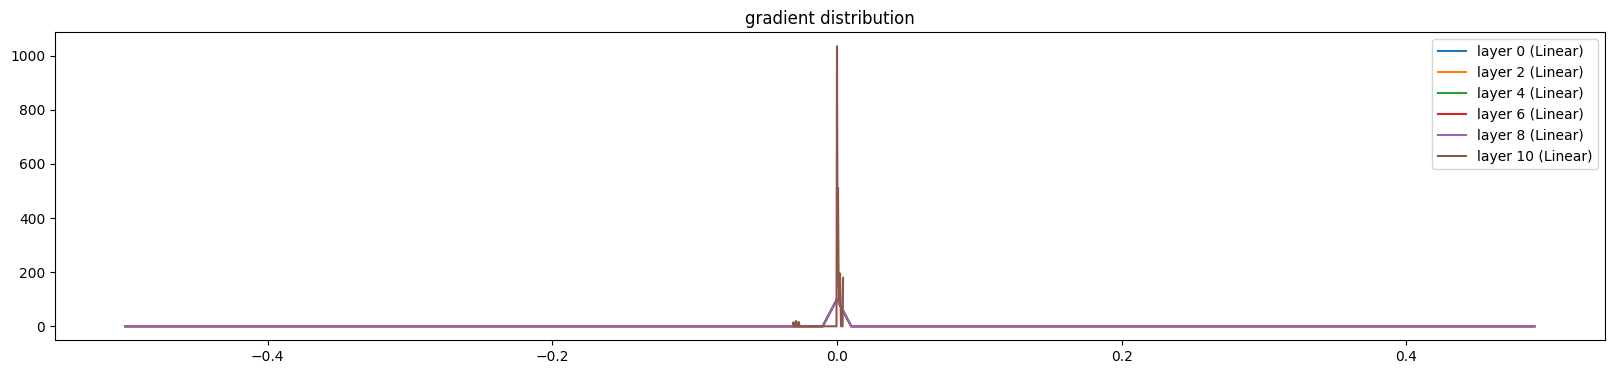

In [186]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # note: exclude the output layer
  if isinstance(layer, Linear):
    print(layer.out)
    t = layer.out.grad
    print(f'grad: {t}')
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__,  t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

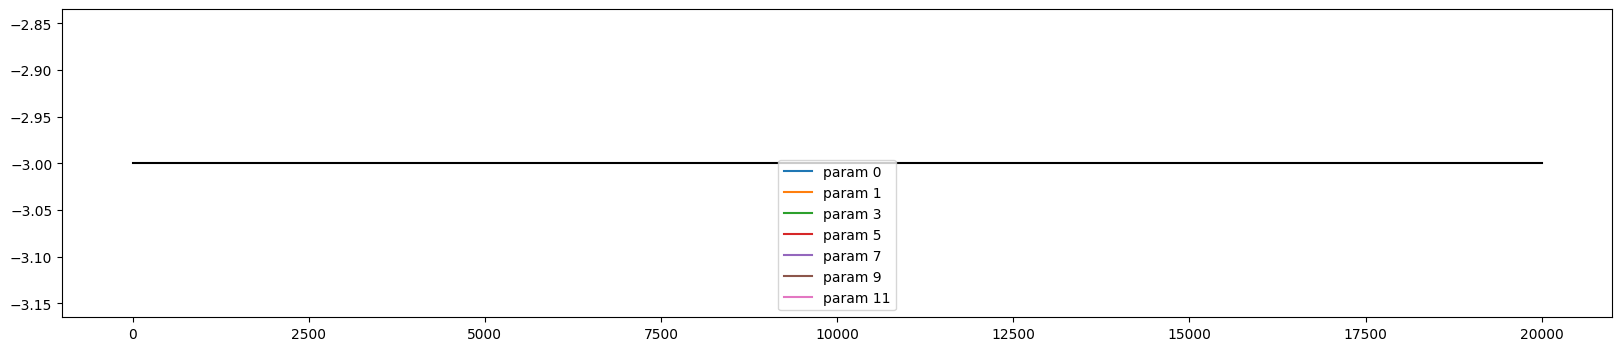

In [187]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [188]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.823330879211426
val 2.821828603744507


tensor([ 1.5674, -0.4713,  0.9849, -1.0725, -0.9648,  0.1156,  0.1351,  0.6169,
        -1.1641, -1.3257, -1.0188, -0.5653, -0.5614, -0.3111,  0.4683,  0.5557,
        -2.1259,  1.7039,  1.2815, -0.2129,  1.2648, -0.2478,  1.3283, -1.0527,
         0.5107, -1.2801, -0.9465], grad_fn=<SelectBackward0>)


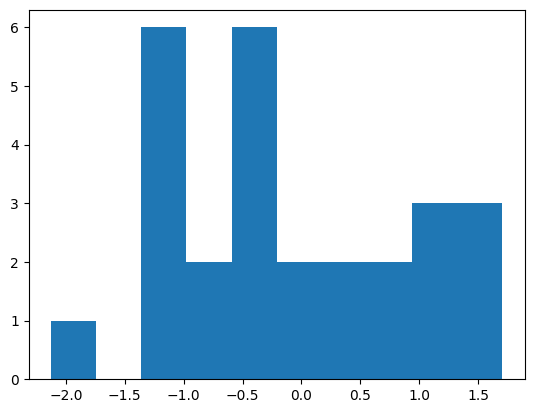

In [165]:
for p in parameters:
    print(p[:,0])
    # hx, hy = torch.histogram(p)
    # print(hx, hy)
    plt.hist(p[:, 0].detach())
    break

In [189]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      with torch.no_grad():
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        print(f'{x}')
        for layer in layers:
          x = layer(x)
          print(f'{layer.__class__.__name__} layer: {layer}  {x}')
        logits = x
        probs = F.softmax(logits, dim=1)
        # print(probs)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
    break

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046,  1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296,
         -1.5471,  0.6049,  0.0791,  0.9046,  1.5674, -0.2373, -0.0274, -1.1008,
          0.2859, -0.0296, -1.5471,  0.6049,  0.0791,  0.9046]])
Linear layer: <__main__.Linear object at 0x2c8e3dd10>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
Tanh layer: <__main__.Tanh object at 0x2c8e3f710>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0

# properly initialized

train 2.0674145221710205
val 2.1056838035583496

In [156]:
[layer for layer in layers if isinstance(layer, Tanh)][0].out.shape

torch.Size([1, 100])

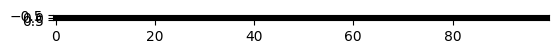

In [157]:
# Inspecting the weights
plt.imshow([layer for layer in layers if isinstance(layer, Tanh)][-1].out.abs() > 0.99, cmap='gray', interpolation='nearest');

In [158]:
plt.hist(h.view(-1).tolist(), 50 );

NameError: name 'h' is not defined

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.



This should be pretty obvious as we're simply scaling and shifting the the activations, which are linear transformations.

In [260]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

16424


In [261]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 20000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.8874
  10000/ 200000: 2.7023
  20000/ 200000: 2.3797


In [301]:
class LinearClone(Linear):
  def __init__(self, weight, bias):
    self.weight = weight
    self.bias = bias


@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

@torch.no_grad() # this decorator disables gradient tracking
def split_loss_frankenstein(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  mod_layers = []
  for i, layer in enumerate(layers):
    if isinstance(layer, BatchNorm1d):
        continue
    elif isinstance(layer, Linear):
        next_layer = layers[i+1]
        if not isinstance(next_layer, BatchNorm1d):
          raise Exception("expected batch norm to be next layer")
        w = layer.weight.clone()
        # print(w.shape)
        # print(next_layer.gamma.shape, next_layer.beta.shape)

        w *= next_layer.gamma.clone()
        w /= torch.sqrt(next_layer.running_var.clone() + 1e-5).view(-1)


        b = torch.zeros_like(next_layer.beta)
        b -= next_layer.running_mean.clone().view(-1)
        b /= torch.sqrt(next_layer.running_var.clone() + 1e-5).view(-1)
        b *= next_layer.gamma.clone()
        b += next_layer.beta.clone()
        # print(next_layer.beta.shape)

        l = LinearClone(w, b)
        mod_layers.append(l)
    else:
        mod_layers.append(layer)

  for layer in mod_layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss_frankenstein('train')
split_loss('train')
split_loss_frankenstein('val')
split_loss('val')

train 2.2414677143096924
train 2.2414677143096924
val 2.250905990600586
val 2.250905990600586


train 2.2414677143096924
train 2.2414677143096924
val 2.250905990600586
val 2.250905990600586

swagggg

In [279]:
# broadcasting test
foo = torch.arange(0, 30).view(-1, 10)
print(foo)
foo.shape

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])


torch.Size([3, 10])

In [282]:
bar = torch.arange(0, 10)
print(bar)
bar.shape

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


torch.Size([10])

In [284]:
# 3, 10
#    10

# fill in 1

# 3, 10
# 1, 10

# duplicate across dimension

# 3, 10
# 3, 10

foo + bar

tensor([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
        [10, 12, 14, 16, 18, 20, 22, 24, 26, 28],
        [20, 22, 24, 26, 28, 30, 32, 34, 36, 38]])